In [6]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
from regression_dsets_large_names import regression_dsets_large_names
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import fit
from process_results import process_results, aggregate_results, best_ridge

%matplotlib inline
%load_ext autoreload
%autoreload 2

parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# basic loading

In [ ]:
print(os.listdir(parent_dir))
out_dir = oj(parent_dir, 'mdl') # basic, pmlb_0, clustered, pmlb_1
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir)])
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not 'processed' in fname]
results = pd.concat(results_list, axis=1).T.infer_objects()

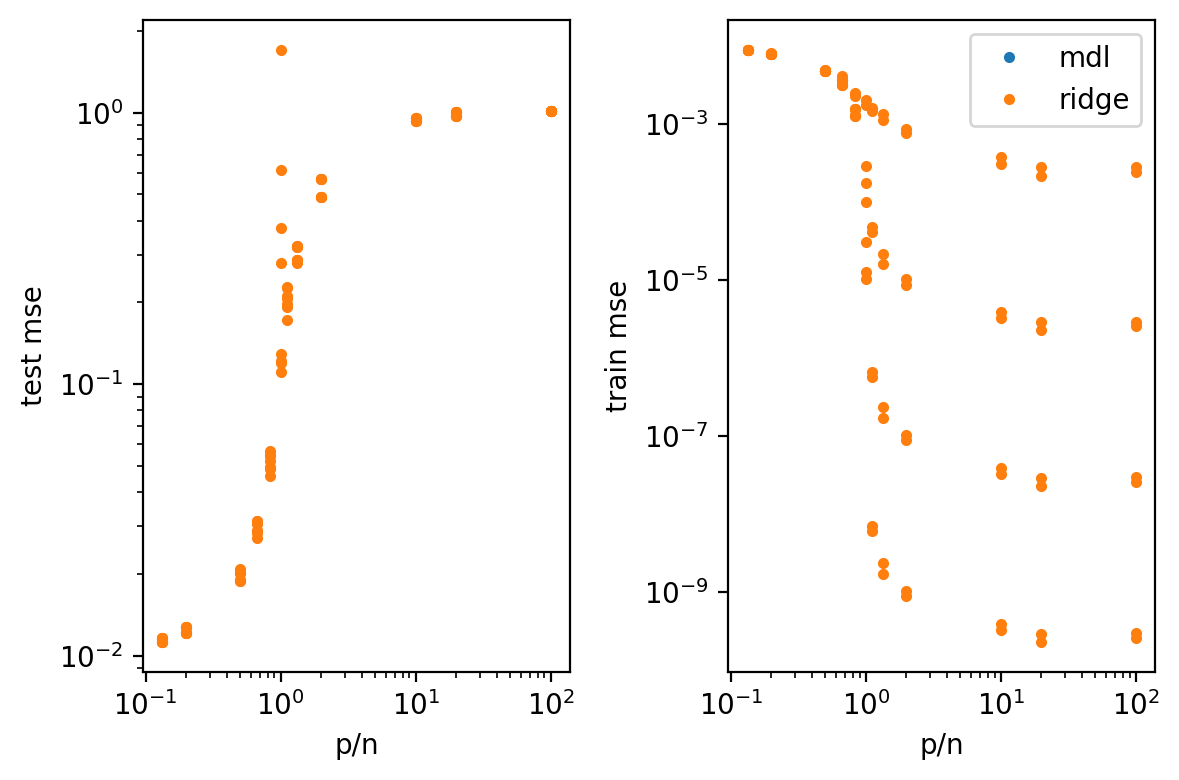

In [4]:
r = results
r = r[r.model_type == 'mdl']
rr = results[results.model_type == 'ridge']
R, C = 1, 2
plt.figure(dpi=200)

plt.subplot(R, C, 1)
plt.plot(1/r.n_train_over_num_features, r.test_mse, '.', label='mdl')
plt.plot(1/rr.n_train_over_num_features, rr.test_mse, '.', label='ridge')
plt.xscale('log')
plt.xlabel('p/n')
plt.ylabel('test mse')
plt.yscale('log')

plt.subplot(R, C, 2)
plt.plot(1/r.n_train_over_num_features, r.train_mse, '.', label='mdl')
plt.plot(1/rr.n_train_over_num_features, rr.train_mse, '.', label='ridge')
plt.xscale('log')
plt.xlabel('p/n')
plt.yscale('log')
plt.ylabel('train mse')
plt.legend()
plt.tight_layout()
plt.show()

# load results from a directory
**note - this script aggregates results - needs to be done to average across trials to make double descent curves**

In [ ]:
# !rm /scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/*/*processed*
!python process_results.py

In [25]:
save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)
# parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/df' # basic, pmlb_0, clustered, pmlb_1
# parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_full' # basic, pmlb_0, clustered, pmlb_1
folders = os.listdir(parent_dir)
print(folders)

['t', 'pmlb0', 'iid_bignoise', 'iid', 'thresh', 'pmlb3', 'bignoise', 'pmlb4', 'decay2', 'gaussian_scale_var', 'decay', 'clustered', 'pmlb1', 'pmlb5', 'pmlb2']


# double-descent plots

In [ ]:
plot_all = False
for folder in folders:
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl'))
        
    if plot_all:
        R, C = 2, 3
    else:
        R, C = 1, 2
    SIZE = 5
    plt.figure(figsize=(C * SIZE, R * SIZE))
    plt.subplot(R, C, 1)
    plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for name, curve in tqdm(df.iterrows()):
    #     print(name, curve)
        model_type = name[3]
        reg_param = name[4]
        l = str(model_type) + ' ' + str(reg_param)
        if model_type == 'ols':
            ls = '--'
        elif model_type == 'ridge':
            ls = ':'
        elif model_type == 'linear_sta':
            ls = '-.'
        elif model_type == 'lasso':
            ls = ':'
        elif 'mdl' in model_type:
            ls = '-'
            
        if not model_type == 'linear_sta':


            kwargs = {'label': l, 'alpha': 0.5, 'lw': 2, 'linestyle': ls}

            plt.subplot(R, C, 1)
        #     plt.plot(curve.ratio, curve.mse_test, 
            plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
            plt.ylabel('test mse')
            plt.xlabel('p / n')

            plt.subplot(R, C, 2)
            plt.plot(curve.ratio, curve.mse_train, **kwargs)
            plt.ylabel('train mse')
            plt.xlabel('p / n')


            if plot_all:
                row_best_ridge = best_ridge(df) # contains df1, df2, df3
                len_ridge = row_best_ridge.df1.size                
                
                plt.subplot(R, C, 4)
                plt.plot(row_best_ridge.df1, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df1: $tr(S S^T)$')

                plt.subplot(R, C, 5)
                plt.plot(row_best_ridge.df2, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df2: $tr(2 * S - S^T S)$')

                plt.subplot(R, C, 6)
                plt.plot(row_best_ridge.df3, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df3: $tr(S)$')


            '''
            plt.subplot(R, C, 3)
            plt.plot(curve.ratio, np.square(curve.bias), **kwargs)
            plt.ylabel('bias')

            plt.subplot(R, C, 4)
            plt.plot(curve.ratio, curve['var'], **kwargs)
            plt.ylabel('var')
            '''

            '''
            # wnorm also recorded
            plt.subplot(R, C, 3)
            plt.plot(curve.ratio, curve['wnorm'], **kwargs)
            plt.ylabel('wnorm')
            plt.xlabel('p / n')

            plt.subplot(R, C, 4)
            plt.plot(curve.ratio, curve['num_nonzero'], **kwargs)
            plt.ylabel('num_nonzero')
            plt.xlabel('p / n')
            '''

    for i in range(1, R * C + 1):
        plt.subplot(R, C, i)
        plt.xscale('log')
        plt.yscale('log')

    #     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    plt.subplot(R, C, 1)
    plt.legend()
    
    if plot_all:
        plt.subplot(R, C, 3)
        ratios = row_best_ridge.ratio
        n = 500 / ratios
        p = 0 * ratios + 500
        plt.plot(ratios, np.minimum(n, p), label='min(n, p)', alpha=0.5)
        plt.plot(ratios, row_best_ridge.df1, label='df1')
        plt.plot(ratios, row_best_ridge.df2, label='df2')
        plt.plot(ratios, row_best_ridge.df3, label='df3')
        plt.xlabel('p / n')
        plt.legend()
    
    
    s = folder
    plt.suptitle(s)
    plt.tight_layout()
    # plt.show()
    plt.savefig(oj(save_dir, s + '.pdf'))
    plt.show()
    plt.close()

**total plot**

6it [00:00, 473.93it/s]
6it [00:00, 481.31it/s]


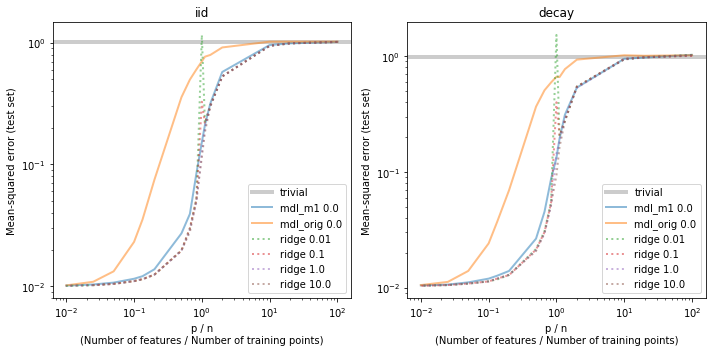

In [22]:
plot_all = False
plt.figure(figsize=(C * SIZE, R * SIZE))
R, C = 1, 2
for i, folder in enumerate(['iid', 'decay']):
    plt.subplot(R, C, i + 1)
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl'))

    SIZE = 5
    
    plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for name, curve in tqdm(df.iterrows()):
    #     print(name, curve)
        model_type = name[3]
        reg_param = name[4]
        l = str(model_type) + ' ' + str(reg_param)
        if model_type == 'ols':
            ls = '--'
        elif model_type == 'ridge':
            ls = ':'
        elif model_type == 'linear_sta':
            ls = '-.'
        elif model_type == 'lasso':
            ls = ':'
        elif 'mdl' in model_type:
            ls = '-'
            
        if not model_type == 'linear_sta':


            kwargs = {'label': l, 'alpha': 0.5, 'lw': 2, 'linestyle': ls}

        #     plt.plot(curve.ratio, curve.mse_test, 
            plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
            plt.ylabel('Mean-squared error (test set)')
            plt.xlabel('p / n\n(Number of features / Number of training points)')
    plt.xscale('log')
    plt.yscale('log')

    #     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    plt.legend()
    
    plt.title(folder)
plt.tight_layout()
plt.show()

# misc

u shape y shape (200, 200) (200,)
(100,) 100 100


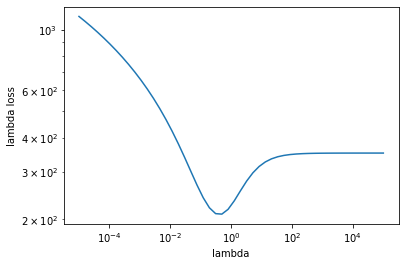

In [176]:
np.random.seed(42)
class p:
    n_train = 200
    num_features = 100
    noise_mult = 0.2
X_train = np.random.randn(p.n_train, p.num_features)
y_train = X_train[:, 0] + X_train[:, 1] + np.random.randn(p.n_train) * p.noise_mult

def lambda_loss(l):
    return np.sum(np.square(a) / (1 + np.square(sv) / l) + np.log(1 + np.square(sv) / l))
U, sv, Vh = npl.svd(X_train / np.sqrt(p.n_train))
print('u shape', 'y shape', U.shape, y_train.shape)
a = U.T @ y_train # / (np.sqrt(p.n_train)) #  np.sqrt(p.noise_mult)
a = a[:sv.size]
print(a.shape, a.size, sv.size)


ls = np.logspace(-5, 5)
plt.loglog(ls, [lambda_loss(l) for l in ls])
plt.ylabel('lambda loss')
plt.xlabel('lambda')
plt.show()

In [138]:
class s:
    pass
s.lambda_opt = minimize(lambda_loss, x0=1e-10).x
inv = npl.pinv(X_train.T @ X_train / p.n_train + s.lambda_opt * np.eye(p.num_features))
s.w = inv @ X_train.T @ y_train / p.n_train